<a href="https://colab.research.google.com/github/79AceVo/Text-analytics/blob/main/Text_Classification_RNN_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks (RNN) for Text Classification

This notebook covers:
1. **Binary Classification** — SimpleRNN for economic news relevance (yes/no)
2. **Multi-class Classification** — SimpleRNN for news topic categorization
3. **Multi-label Classification** — SimpleRNN for tagging articles with multiple topics
4. **Hyperparameter Tuning** — Systematic experiments with batch size, epochs, neurons, dropout

---
### What is an RNN?
An RNN processes text **one word at a time**, maintaining a hidden state (memory) that carries information forward through the sequence.

**Strengths**: Simple, fast to train, captures basic sequential patterns
**Weakness**: Suffers from **vanishing gradient** — memory fades over long sequences (>20 words)
**When to use**: Baseline model, short text classification, when training speed matters

#Enable GPU prior to run

In Colab, change Runtime to T4 for faster processing.

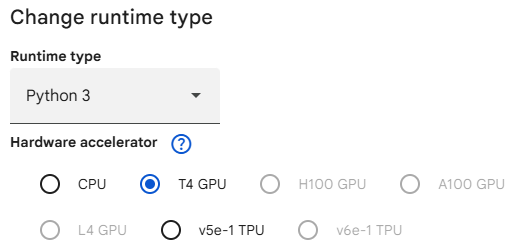

Normal runtime will takes much longer


## Part 0: Setup & Data Preparation

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

import string, re, warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ============================================================
# ⚡ CONFIGURATION — Adjust these for speed vs accuracy
# ============================================================
MAX_LEN = 500         # max sequence length (tokens)
VOCAB_SIZE = 5000     # vocabulary size
EMBED_DIM = 32        # embedding dimensions (smaller = faster)
BATCH_SIZE = 128      # batch size (larger = faster on GPU)
EPOCHS = 5            # max epochs
PATIENCE = 3          # early stopping patience

print(f"Config: MAX_LEN={MAX_LEN}, VOCAB={VOCAB_SIZE}, EMBED={EMBED_DIM}")
print(f"        BATCH={BATCH_SIZE}, EPOCHS={EPOCHS}, PATIENCE={PATIENCE}")

Config: MAX_LEN=500, VOCAB=5000, EMBED=32
        BATCH=128, EPOCHS=5, PATIENCE=3


In [3]:
# ============================================================
# DATA PATH — Works on both Colab and local
# ============================================================
import os, subprocess

# GitHub repo URL for raw data files
REPO = "https://raw.githubusercontent.com/79AceVo/Text-analytics/main/Data"

def get_data(filename, sep=',', encoding=None):
    """Load CSV from local Data/ folder or download from GitHub."""
    local_paths = [
        f"Data/{filename}",             # local: Data/ subfolder
        filename,                        # local: same directory
        f"/content/Data/{filename}",     # Colab: mounted drive
        f"/content/{filename}",          # Colab: uploaded file
    ]

    # Try local paths first
    for path in local_paths:
        if os.path.exists(path):
            print(f"✅ Found locally: {path}")
            return pd.read_csv(path, sep=sep, low_memory=False, encoding=encoding)

    # Download from GitHub
    url = f"{REPO}/{filename}"
    print(f"⬇️  Downloading from GitHub: {filename}...")
    try:
        df = pd.read_csv(url, sep=sep, low_memory=False, encoding=encoding)
        print(f"✅ Downloaded ({len(df)} rows)") # Fixed: Removed unescaped newline
        return df
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print(f"   Please place {filename} in a Data/ folder or upload it.")
        raise

print("✅ get_data() ready — checks local paths first, downloads from GitHub if needed")

✅ get_data() ready — checks local paths first, downloads from GitHub if needed


In [4]:
# LOAD DATA
df = get_data("econ_news.csv", encoding="ISO-8859-1")
print(f"Shape: {df.shape}")
df.head(3)

⬇️  Downloading from GitHub: econ_news.csv...
✅ Downloaded (8000 rows)
Shape: (8000, 15)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.00,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.00,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...


Class distribution (raw counts):
relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

Class distribution (percentages):
relevance
no          0.821
yes         0.178
not sure    0.001
Name: proportion, dtype: float64


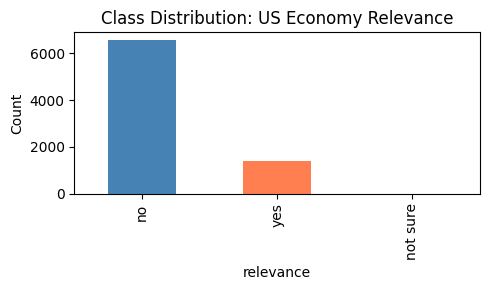


⚠️ Note: ~82% 'no' vs ~17% 'yes' — this is an IMBALANCED dataset.
   We'll use class_weight to handle this during training.


In [5]:
# ============================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================
print("Class distribution (raw counts):")
print(df["relevance"].value_counts())
print("\nClass distribution (percentages):")
print(df["relevance"].value_counts(normalize=True).round(3))

# Visualize class imbalance
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
df["relevance"].value_counts().plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
ax.set_title("Class Distribution: US Economy Relevance")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()
print("\n⚠️ Note: ~82% 'no' vs ~17% 'yes' — this is an IMBALANCED dataset.")
print("   We'll use class_weight to handle this during training.")

In [6]:
# ============================================================
# DATA PREPROCESSING
# ============================================================
# Remove ambiguous labels
df = df[df["relevance"] != "not sure"]

# Binary encode: yes=1, no=0
df["relevance"] = df["relevance"].map({'yes': 1, 'no': 0})

# Keep only what we need
data = df[["text", "relevance"]].copy()
print(f"Clean dataset shape: {data.shape}")
print(f"Class balance: {data['relevance'].value_counts().to_dict()}")

Clean dataset shape: (7991, 2)
Class balance: {0: 6571, 1: 1420}


In [7]:
# ============================================================
# TEXT CLEANING FUNCTION
# ============================================================
stop_words = set(stopwords.words('english'))

def clean(doc):
    """Remove HTML, punctuation, digits, stopwords"""
    doc = doc.replace("</br>", " ")
    tokens = doc.split()
    tokens = [t for t in tokens
              if t not in string.punctuation
              and not t.isdigit()
              and t not in stop_words]
    return " ".join(tokens)

data["text"] = data["text"].apply(clean)
print("Sample cleaned text:")
print(data["text"].iloc[0][:200], "...")

Sample cleaned text:
NEW YORK -- Yields certificates deposit offered major banks dropped tenth percentage point latest week, reflecting overall decline short-term interest rates. On small-denomination, "consumer," CDs sol ...


In [8]:
# ============================================================
# TRAIN-TEST SPLIT & VECTORIZATION
# ============================================================
X = data["text"]
y = data["relevance"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")
print(f"Train class balance: {y_train.value_counts().to_dict()}")

# Vectorize with CountVectorizer
vect = CountVectorizer(preprocessor=clean, max_features=10000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(f"Vocabulary size: {len(vect.vocabulary_)}")

# Pad sequences for neural network input
MAX_LEN = 5000
X_train_dense = pad_sequences(X_train_dtm.toarray(), maxlen=MAX_LEN, padding='post', truncating='post')
X_test_dense = pad_sequences(X_test_dtm.toarray(), maxlen=MAX_LEN, padding='post', truncating='post')
print(f"Padded input shape: {X_train_dense.shape}")

Train: 5993 samples | Test: 1998 samples
Train class balance: {0: 4928, 1: 1065}
Vocabulary size: 10000
Padded input shape: (5993, 5000)


In [9]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    """Create optimized tf.data pipeline with cache + prefetch."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X), seed=42)
    ds = ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    return ds

def plot_history(history, title="Model"):
    """Plot training & validation loss and accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['loss'], label='Train', color='steelblue')
    ax1.plot(history.history['val_loss'], label='Val', color='coral')
    ax1.set_title(f'{title} — Loss'); ax1.set_xlabel('Epoch')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    acc_key = [k for k in history.history if 'accuracy' in k and 'val' not in k][0]
    val_key = 'val_' + acc_key
    ax2.plot(history.history[acc_key], label='Train', color='steelblue')
    ax2.plot(history.history[val_key], label='Val', color='coral')
    ax2.set_title(f'{title} — Accuracy'); ax2.set_xlabel('Epoch')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def evaluate_binary(model, X_test, y_test, title="Model"):
    """Evaluate binary classifier with report + confusion matrix."""
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    print(f"\n{'='*50}\n  {title}\n{'='*50}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(4, 3))
    disp.plot(ax=ax, cmap='Blues'); ax.set_title(title)
    plt.tight_layout(); plt.show()

def evaluate_multiclass(model, X_test, y_test, class_names, title="Model"):
    """Evaluate multi-class classifier."""
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print(f"\n{'='*50}\n  {title}\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45, ha='right'); ax.set_title(title)
    plt.tight_layout(); plt.show()

def evaluate_multilabel(model, X_test, y_test, label_names, title="Model"):
    """Evaluate multi-label classifier."""
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    print(f"\n{'='*50}\n  {title} — Multi-Label\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))
    print("Per-label accuracy:")
    for i, name in enumerate(label_names):
        print(f"  {name}: {accuracy_score(y_test[:, i], y_pred[:, i]):.3f}")

print("✅ Helpers ready (make_dataset, plot_history, evaluate functions)")

✅ Helpers ready (make_dataset, plot_history, evaluate functions)


In [10]:
# ============================================================
# EARLY STOPPING — The Smart Way to Choose Epochs
# ============================================================
# Instead of guessing epochs, let the model tell us when to stop.
# patience=5 means: stop if val_loss hasn't improved in 5 epochs.
# restore_best_weights=True means: use the weights from the best epoch.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
print("✅ EarlyStopping callback ready (patience=5, restore_best_weights=True)")

✅ EarlyStopping callback ready (patience=5, restore_best_weights=True)


---
## Part 1: Binary Classification with SimpleRNN
**Task**: Classify economic news as relevant (1) or not relevant (0) to the US economy.

**Architecture choices:**
- `Embedding(output_dim=64)` → converts word indices to 64-dim vectors
- `SimpleRNN(32)` → 32-unit RNN processes the sequence
- `Dense(1, sigmoid)` → single output for binary probability
- `binary_crossentropy` loss — standard for binary tasks
- `class_weight={0:1, 1:2}` — handles class imbalance (minority class gets 2x weight)

In [11]:
# ============================================================
# MODEL 1A: Simple RNN — Binary Classification (Baseline)
# ============================================================
model_rnn_binary = keras.Sequential([
    layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=64),
    layers.SimpleRNN(32),                          # 32-unit RNN
    layers.Dropout(0.3),                           # prevent overfitting
    layers.Dense(1, activation='sigmoid')          # binary output
], name="RNN_Binary_Baseline")

model_rnn_binary.compile(
    loss='binary_crossentropy',                    # binary task → BCE
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)



In [12]:
import time

# Train with class weights to handle imbalance
class_weights = {0: 1, 1: 2}  # minority class (relevant=1) gets 2x weight

train_start = time.time()
history_rnn_binary = model_rnn_binary.fit(
    X_train_dense, y_train,
    epochs=5,                                     # set high — early stopping will handle it
    batch_size=32,
    validation_data=(X_test_dense, y_test),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")
model_rnn_binary.summary()

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 317ms/step - accuracy: 0.7580 - loss: 0.7593 - val_accuracy: 0.8223 - val_loss: 0.5141
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.8259 - loss: 0.7231 - val_accuracy: 0.8223 - val_loss: 0.5107
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 76s 306ms/step - accuracy: 0.8165 - loss: 0.7345 - val_accuracy: 0.8223 - val_loss: 0.5062
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 311ms/step - accuracy: 0.8200 - loss: 0.7290 - val_accuracy: 0.8223 - val_loss: 0.5169
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 307ms/step - accuracy: 0.8304 - loss: 0.7047 - val_accuracy: 0.7743 - val_loss: 0.5302
Restoring model weights from the end of the best epoch: 3.

⏱️ Training time: 343.4 seconds


Model: "RNN_Binary_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969,413 (3.70 MB)

 Trainable params: 323,137 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 646,276 (2.47 MB)

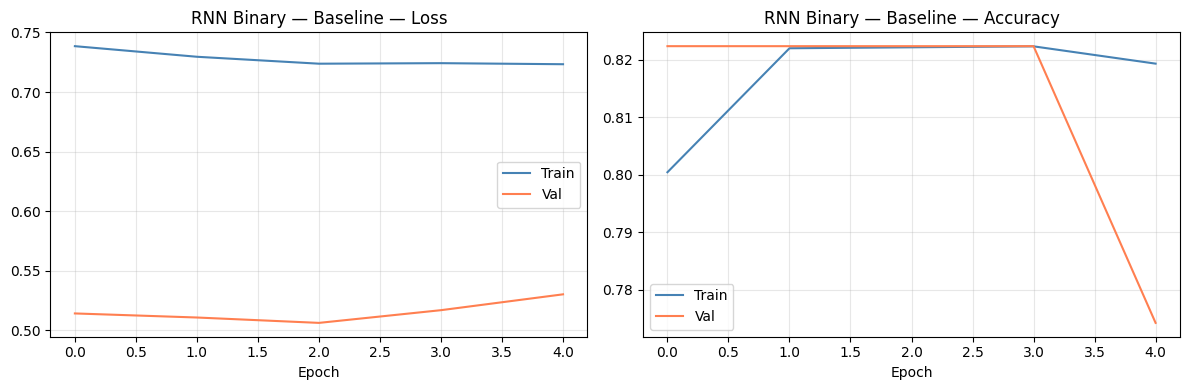


  RNN Binary Baseline
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1643
           1       0.00      0.00      0.00       355

    accuracy                           0.82      1998
   macro avg       0.41      0.50      0.45      1998
weighted avg       0.68      0.82      0.74      1998



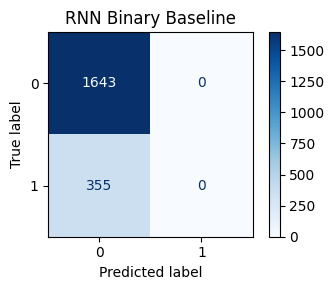

In [13]:
# Visualize training curves
plot_history(history_rnn_binary, "RNN Binary — Baseline")

# Evaluate
y_pred_rnn = evaluate_binary(model_rnn_binary, X_test_dense, y_test, "RNN Binary Baseline")

---
## Part 2: Multi-class Classification with SimpleRNN
**Task**: Classify news into 3 categories based on relevance level.

For multi-class, we change:
- **Output layer**: `Dense(num_classes, activation='softmax')` — probability distribution over K classes
- **Loss**: `sparse_categorical_crossentropy` — because labels are integers (0, 1, 2)
- **Labels**: We create 3 synthetic categories from the binary labels for demonstration

In [14]:
# ============================================================
# LOAD DATA — BBC News (Multi-class: 5 categories)
# ============================================================
bbc_df = get_data('bbc-news-data.csv', sep='\t')
print(f"Shape: {bbc_df.shape}")
print(f"\nCategory distribution:")
print(bbc_df['category'].value_counts())

# Clean text (title + content combined)
bbc_df['clean'] = (bbc_df['title'] + ' ' + bbc_df['content']).apply(clean)

# Encode labels
le = LabelEncoder()
bbc_df['target'] = le.fit_transform(bbc_df['category'])
class_names = list(le.classes_)
num_classes = len(class_names)
print(f"\nClasses: {dict(zip(class_names, range(num_classes)))}")

⬇️  Downloading from GitHub: bbc-news-data.csv...
✅ Downloaded (2225 rows)
Shape: (2225, 4)

Category distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Classes: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [15]:
# ============================================================
# TOKENIZE & PAD — Multi-class
# ============================================================
tokenizer_mc = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_mc.fit_on_texts(bbc_df['clean'])

X_mc = pad_sequences(tokenizer_mc.texts_to_sequences(bbc_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_mc = bbc_df['target'].values

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.25, random_state=42, stratify=y_mc)
print(f"Train: {X_train_mc.shape} | Test: {X_test_mc.shape}")

train_mc_ds = make_dataset(X_train_mc, y_train_mc)
test_mc_ds = make_dataset(X_test_mc, y_test_mc, shuffle=False)
print(f"✅ Multi-class pipelines ready")

Train: (1668, 5000) | Test: (557, 5000)
✅ Multi-class pipelines ready


In [24]:
# ============================================================
# MODEL 2: RNN — Multi-class Classification
# ============================================================
model_rnn_multi = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
    layers.SimpleRNN(64),                                     # more units for 3 classes
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),                      # additional hidden layer
    layers.Dense(num_classes, activation='softmax')            # SOFTMAX for multi-class
], name="RNN_MultiClass")

model_rnn_multi.compile(
    loss='sparse_categorical_crossentropy',                    # integer labels → sparse CCE
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.2100 - loss: 1.6168 - val_accuracy: 0.2298 - val_loss: 1.6209
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 336ms/step - accuracy: 0.2054 - loss: 1.6451 - val_accuracy: 0.2298 - val_loss: 1.6053
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 336ms/step - accuracy: 0.2216 - loss: 1.6423 - val_accuracy: 0.2298 - val_loss: 1.6082
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.2138 - loss: 1.6139 - val_accuracy: 0.1795 - val_loss: 1.6129
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.2124 - loss: 1.6101 - val_accuracy: 0.2298 - val_loss: 1.6054
Restoring model weights from the end of the best epoch: 2.

⏱️ Training time: 114.1 seconds


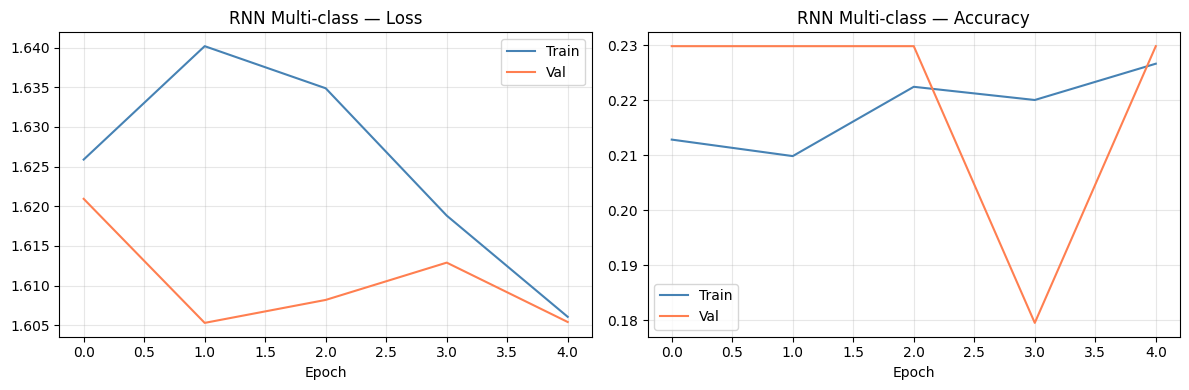


  RNN Multi-class
               precision    recall  f1-score   support

     business       0.23      1.00      0.37       128
entertainment       0.00      0.00      0.00        97
     politics       0.00      0.00      0.00       104
        sport       0.00      0.00      0.00       128
         tech       0.00      0.00      0.00       100

     accuracy                           0.23       557
    macro avg       0.05      0.20      0.07       557
 weighted avg       0.05      0.23      0.09       557



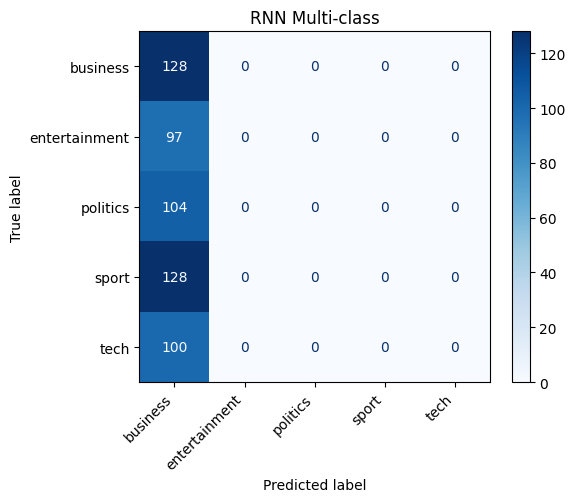

In [17]:
import time

# Train multi-class RNN
es_mc = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

train_start = time.time()
history_rnn_multi = model_rnn_multi.fit(
    X_train_mc, y_train_mc,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_mc, y_test_mc),
    callbacks=[es_mc],
    verbose=1
)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history_rnn_multi, "RNN Multi-class")
y_pred_mc = evaluate_multiclass(model_rnn_multi, X_test_mc, y_test_mc, class_names, "RNN Multi-class")

In [18]:
model_rnn_multi.summary()

Model: "RNN_MultiClass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,505 (3.78 MB)

 Trainable params: 330,501 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 661,004 (2.52 MB)

---
## Part 3: Multi-label Classification with SimpleRNN
**Task**: Tag each article with **one or more** topics simultaneously.

Multi-label is fundamentally different from multi-class:
- **Multi-class**: One correct answer (softmax, outputs sum to 1)
- **Multi-label**: Multiple correct answers (sigmoid on each output, independent probabilities)

Key changes:
- **Output**: `Dense(num_labels, activation='sigmoid')` — independent probability per label
- **Loss**: `binary_crossentropy` — each label is a separate binary decision
- **Labels**: Binary matrix (not one-hot, not integers)

In [19]:
# ============================================================
# LOAD DATA — Toxic Comments (Multi-label: 6 labels)
# ============================================================
toxic_df = get_data('toxic_comments_1k.csv')

# Keep rows with actual text
toxic_df = toxic_df[toxic_df['comment_text'].notna()].copy()
print(f"Shape (with text): {toxic_df.shape}")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for col in label_cols:
    toxic_df[col] = toxic_df[col].fillna(0).astype(int)

print(f"\nLabel distribution:")
for col in label_cols:
    print(f"  {col}: {toxic_df[col].sum()} positive ({toxic_df[col].mean()*100:.1f}%)")
print(f"Avg labels per comment: {toxic_df[label_cols].sum(axis=1).mean():.2f}")

# Clean text
toxic_df['clean'] = toxic_df['comment_text'].apply(clean)

⬇️  Downloading from GitHub: toxic_comments_1k.csv...
✅ Downloaded (9999 rows)
Shape (with text): (9999, 8)

Label distribution:
  toxic: 971 positive (9.7%)
  severe_toxic: 101 positive (1.0%)
  obscene: 527 positive (5.3%)
  threat: 33 positive (0.3%)
  insult: 494 positive (4.9%)
  identity_hate: 84 positive (0.8%)
Avg labels per comment: 0.22


In [20]:
# ============================================================
# TOKENIZE & PAD — Multi-label
# ============================================================
tokenizer_ml = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_ml.fit_on_texts(toxic_df['clean'])

X_ml = pad_sequences(tokenizer_ml.texts_to_sequences(toxic_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_ml = toxic_df[label_cols].values.astype(np.float32)
num_labels = len(label_cols)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.25, random_state=42)
print(f"Train: {X_train_ml.shape} | Labels: {y_train_ml.shape}")

train_ml_ds = make_dataset(X_train_ml, y_train_ml)
test_ml_ds = make_dataset(X_test_ml, y_test_ml, shuffle=False)
print(f"✅ Multi-label pipelines ready")

Train: (7499, 5000) | Labels: (7499, 6)
✅ Multi-label pipelines ready


In [31]:
# ============================================================
# MODEL 3: RNN — Multi-label Classification
# ============================================================
# KEY DIFFERENCES:
# 1. Output: Dense(num_labels, activation='sigmoid') — independent sigmoid per label
# 2. Loss: binary_crossentropy — each label is a binary decision
# 3. Threshold: predict label if probability > 0.5

# Ensure num_labels is correctly set based on the data
num_labels = len(label_cols) # This should be 6, derived from label_cols

model_rnn_ml = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
    layers.SimpleRNN(64),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='sigmoid')             # SIGMOID for multi-label (NOT softmax!)
], name="RNN_MultiLabel")

model_rnn_ml.compile(
    loss='binary_crossentropy',                                # BCE for multi-label
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy']
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 88s 358ms/step - binary_accuracy: 0.8999 - loss: 0.2770 - val_binary_accuracy: 0.9652 - val_loss: 0.1358
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 337ms/step - binary_accuracy: 0.9625 - loss: 0.1479 - val_binary_accuracy: 0.9652 - val_loss: 0.1376
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 336ms/step - binary_accuracy: 0.9611 - loss: 0.1540 - val_binary_accuracy: 0.9652 - val_loss: 0.1358
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 337ms/step - binary_accuracy: 0.9637 - loss: 0.1421 - val_binary_accuracy: 0.9652 - val_loss: 0.1363
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 80s 340ms/step - binary_accuracy: 0.9616 - loss: 0.1488 - val_binary_accuracy: 0.9652 - val_loss: 0.1366
Restoring model weights from the end of the best epoch: 3.

⏱️ Training time: 405.5 seconds


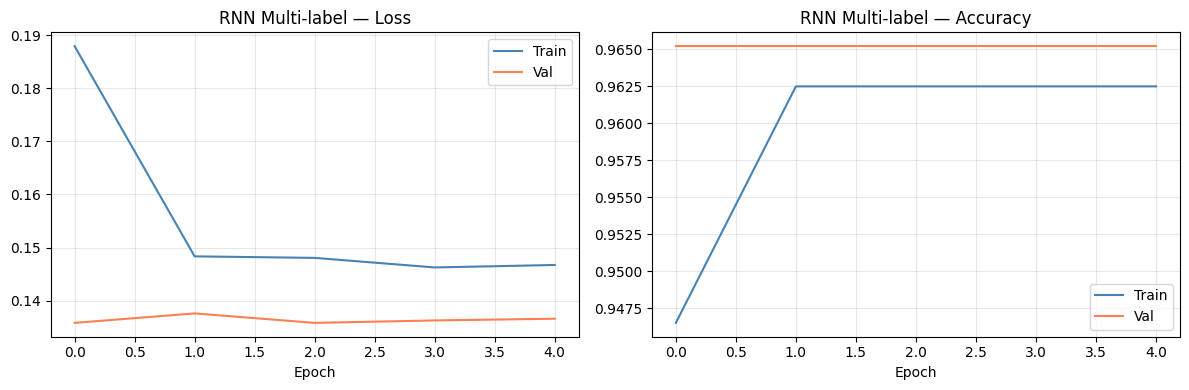


  RNN Multi-label — Multi-Label
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00       235
 severe_toxic       0.00      0.00      0.00        28
      obscene       0.00      0.00      0.00       121
       threat       0.00      0.00      0.00         8
       insult       0.00      0.00      0.00       114
identity_hate       0.00      0.00      0.00        16

    micro avg       0.00      0.00      0.00       522
    macro avg       0.00      0.00      0.00       522
 weighted avg       0.00      0.00      0.00       522
  samples avg       0.00      0.00      0.00       522

Per-label accuracy:
  toxic: 0.906
  severe_toxic: 0.989
  obscene: 0.952
  threat: 0.997
  insult: 0.954
  identity_hate: 0.994


In [32]:
import time

# Train multi-label RNN
es_ml = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

train_start = time.time()
history_rnn_ml = model_rnn_ml.fit(
    X_train_ml, y_train_ml,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_ml, y_test_ml),
    callbacks=[es_ml],
    verbose=1
)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history_rnn_ml, "RNN Multi-label")
y_pred_ml = evaluate_multilabel(model_rnn_ml, X_test_ml, y_test_ml, label_cols, title="RNN Multi-label")

In [33]:
model_rnn_ml.summary()
print("\n⚠️ Notice: sigmoid output + binary_crossentropy — NOT softmax!")
print("   Each output is an independent binary decision.")

Model: "RNN_MultiLabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 5000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,604 (3.78 MB)

 Trainable params: 330,534 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 661,070 (2.52 MB)


⚠️ Notice: sigmoid output + binary_crossentropy — NOT softmax!
   Each output is an independent binary decision.


---
## Summary: RNN for Text Classification

| Task | Output Activation | Loss Function | Label Format |
|---|---|---|---|
| **Binary** | `sigmoid` (1 neuron) | `binary_crossentropy` | 0 or 1 |
| **Multi-class** | `softmax` (K neurons) | `sparse_categorical_crossentropy` | Integer (0,1,2...) |
| **Multi-label** | `sigmoid` (K neurons) | `binary_crossentropy` | Binary matrix |

### RNN Limitations
- **Vanishing gradient**: Memory fades over long sequences — struggles with documents > 50 words
- **No gates**: Cannot selectively remember or forget — everything decays at the same rate
- **Sequential processing**: Cannot parallelize — slow on long sequences